Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import files 
files.upload()

data = pd.read_csv("avocado.csv")
data

Saving avocado.csv to avocado.csv


Unnamed: 0        Date  ...  year            region
0               0  27-12-2015  ...  2015            Albany
1               1  20-12-2015  ...  2015            Albany
2               2  13-12-2015  ...  2015            Albany
3               3  06-12-2015  ...  2015            Albany
4               4  29-11-2015  ...  2015            Albany
...           ...         ...  ...   ...               ...
18244           7  04-02-2018  ...  2018  WestTexNewMexico
18245           8  28-01-2018  ...  2018  WestTexNewMexico
18246           9  21-01-2018  ...  2018  WestTexNewMexico
18247          10  14-01-2018  ...  2018  WestTexNewMexico
18248          11  07-01-2018  ...  2018  WestTexNewMexico

[18249 rows x 14 columns]

Cleaning Data and making it more readable

In [2]:
encode = LabelEncoder()
data['region'] = encode.fit_transform(data['region'])
data['type'] = data['type'].map({'conventional': 0, 'organic':1})

data.drop("Unnamed: 0",axis=1,inplace=True)  # dropping the id column from dataset
print(data)
data.rename(columns={'4046':'Small avocados', '4225':'Large avocados', '4770':'XLarge avocados'}, inplace=True)

print(data)

data['type'].unique()

             Date  AveragePrice  Total Volume  ...  type  year  region
0      27-12-2015          1.33      64236.62  ...     0  2015       0
1      20-12-2015          1.35      54876.98  ...     0  2015       0
2      13-12-2015          0.93     118220.22  ...     0  2015       0
3      06-12-2015          1.08      78992.15  ...     0  2015       0
4      29-11-2015          1.28      51039.60  ...     0  2015       0
...           ...           ...           ...  ...   ...   ...     ...
18244  04-02-2018          1.63      17074.83  ...     1  2018      53
18245  28-01-2018          1.71      13888.04  ...     1  2018      53
18246  21-01-2018          1.87      13766.76  ...     1  2018      53
18247  14-01-2018          1.93      16205.22  ...     1  2018      53
18248  07-01-2018          1.62      17489.58  ...     1  2018      53

[18249 rows x 13 columns]
             Date  AveragePrice  Total Volume  ...  type  year  region
0      27-12-2015          1.33      64236.62  ...

array([0, 1])

Feature Engineering ==> Splitting the data column into month and day 

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].apply(lambda x:x.month)
data['Day'] = data['Date'].apply(lambda x:x.day)
data['Year'] = data['Date'].apply(lambda x:x.year)
data.head()
data.shape

(18249, 16)

Finding Correlated features

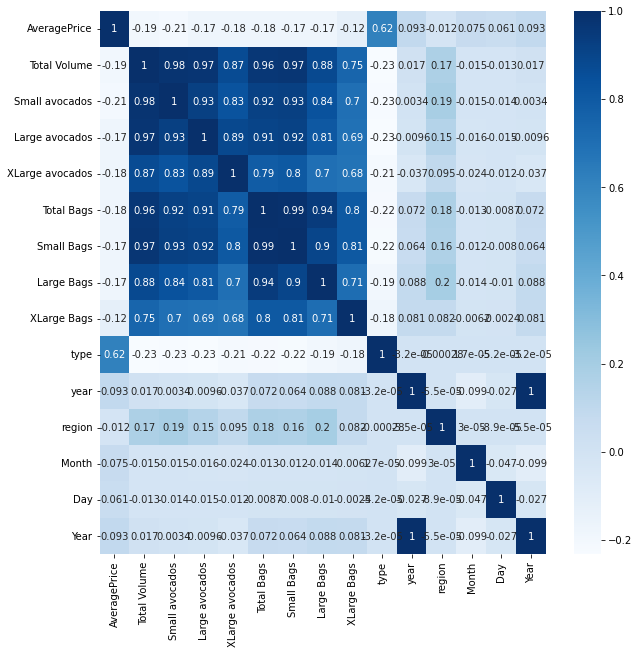

In [4]:
plt.figure(figsize=(10,10))
#print(data.corr())
sns.heatmap(data.corr(),cmap='Blues',annot=True)

Splitting the dataset into train and test set 

In [5]:
X = data.iloc[:,3:]
Y = data.iloc[:,2]
#print(X)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Building the XGBoost Regressor model 

In [6]:
import xgboost as xgb


xgb_reg = xgb.XGBRegressor(booster='gbtree', verbosity=0)
xgb_reg.fit(x_train, y_train, eval_metric='auc')

XGBRegressor(verbosity=0)

In [7]:
y_pred = xgb_reg.predict(x_test)
print(y_pred)

[ 14992.112  79018.336 182946.73  ... 365946.12   32607.783  14411.022]


In [8]:
print("Score for XGBoost model is {:.2f}% ".format(xgb_reg.score(x_test, y_test)*100))

Score for XGBoost model is 99.87% 


Hyperparameter Tuning for XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

param = {'min_child_weight':[2,4,6,10], 'max_depth':[3,5,7,9,10], 'gamma':[1,5]}

gs = GridSearchCV(estimator = xgb_reg, param_grid = param, cv=10, verbose=True) 
gs = gs.fit(x_train, y_train)

best_params=gs.best_params_
print("After hyperparameter tuning we found these paramaters to be most precise ",best_params)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
After hyperparameter tuning we found these paramaters to be most precise  {'gamma': 1, 'max_depth': 9, 'min_child_weight': 2}
0.9990290733772742


In [15]:
best_score = gs.best_estimator_.score(x_test,y_test)
print("Best score achieved after hyperparameter tuning is {:.2f}%".format(best_score*100))

Best score achieved after hyperparameter tuning is 99.90%


min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.This refers to min “sum of weights” of observations.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can lead to under-fitting.

max_depth [default=6]
The maximum depth of a tree. Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.Typical values are 3-10

gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.

How XGBoost works ?



XGBoost is a decision tree based ensemble algorithm that uses gradient boosting framework. The base model predict the avocado price based on all features and the model result in some loss. This loss will be optimized in the following model which will have input as target feature predicted by base model and the loss suffered. This step is repeated until the loss is optimized(minimized). 